In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

In [54]:
df_raw = sns.load_dataset('flights')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


In [55]:
df_baking = df_raw.copy()
df_baking['month'] = pd.to_datetime(df_baking['month'], format='%b').dt.month
df_baking['year'] = pd.to_datetime(df_baking['year'], format='%Y').dt.year
df_baking['date'] = pd.to_datetime(df_baking[['year','month']].assign(day=1)) + pd.offsets.MonthEnd(1)
df_baking = df_baking.drop(columns=['month','year'])
df_baking = df_baking.set_index('date')
df = df_baking['passengers'].copy()
df = df.resample('ME').sum()
df

date
1949-01-31    112
1949-02-28    118
1949-03-31    132
1949-04-30    129
1949-05-31    121
             ... 
1960-08-31    606
1960-09-30    508
1960-10-31    461
1960-11-30    390
1960-12-31    432
Freq: ME, Name: passengers, Length: 144, dtype: int64

In [56]:
display(df.to_frame().reset_index().describe().T)


,count,mean,min,25%,50%,75%,max,std
date,144,1955-01-14 15:30:00,1949-01-31 00:00:00,1952-01-23 06:00:00,1955-01-15 12:00:00,1958-01-07 18:00:00,1960-12-31 00:00:00,NaN
passengers,144.0,280.298611,104.0,180.0,265.5,360.5,622.0,119.966317


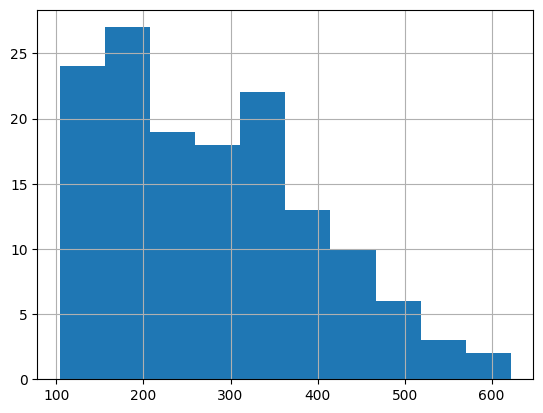

In [57]:
df.hist()
plt.show()

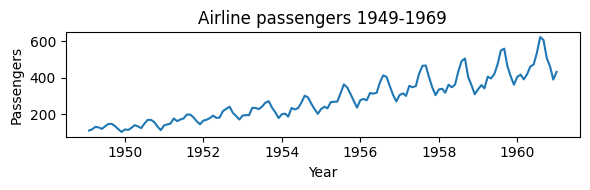

In [58]:
plt.figure(figsize=(6,2))
plt.plot(df)
plt.title('Airline passengers 1949-1969')
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.tight_layout()
plt.show()

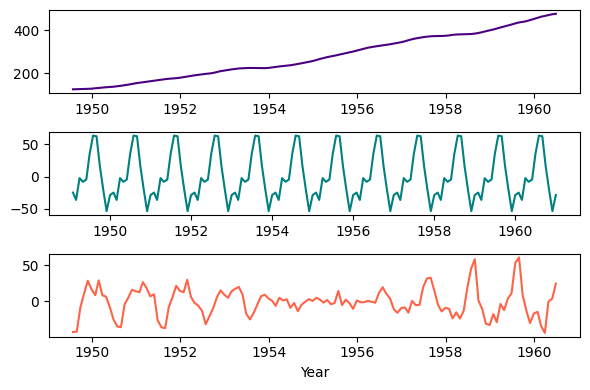

In [59]:
decomposition = seasonal_decompose(df)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
fig, ax = plt.subplots(3, 1, figsize=(6,4))
ax[0].plot(trend, c='indigo')
ax[1].plot(seasonal, c='teal')
ax[2].plot(residual, c='tomato')
plt.xlabel('Year')
plt.tight_layout()
plt.show()

In [60]:
# Test stationarity
dickey_fuller = adfuller(df)
print(f"ADF Statistic: {dickey_fuller[0]:.2f}")
print(f"p-value: {dickey_fuller[1]:.2f}")

ADF Statistic: 0.82
p-value: 0.99


In [61]:
# First differencing
df_1diff = df.diff(1).dropna()
dickey_fuller = adfuller(df_1diff)
print(f"ADF Statistic: {dickey_fuller[0]:.2f}")
print(f"p-value: {dickey_fuller[1]:.2f}")

ADF Statistic: -2.83
p-value: 0.05


In [62]:
# Second differencing
df_2diff = df.diff(1).diff(1).dropna()
dickey_fuller = adfuller(df_2diff)
print(f"ADF Statistic: {dickey_fuller[0]:.2f}")
print(f"p-value: {dickey_fuller[1]:.2f}")

ADF Statistic: -16.38
p-value: 0.00


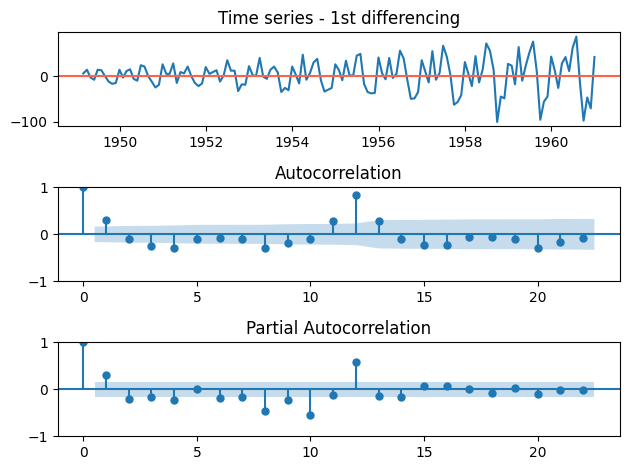

In [63]:
fig, ax = plt.subplots(3,1)
ax[0].plot(df_1diff)
ax[0].axhline(y=0, c='tomato')
ax[0].set_title("Time series - 1st differencing")
plot_acf(df_1diff, ax=ax[1])
plot_pacf(df_1diff, ax=ax[2])
plt.tight_layout()
plt.show()

In [ ]:
grid = []
for p in range(3):
    for d in range(2):
        for q in range(2):
            for P in range(2):
                for D in range(2):
                    for Q in range(4):
                        model = sm.tsa.SARIMAX(
                            df, order=(p,d,q), seasonal_order=(P,D,Q,12),
                            enforce_invertibility=False,
                            enforce_stationarity=False)
                        results = model.fit()
                        orders = f"{p}_{d}_{q}_{P}_{D}_{Q}"
                        grid.append((orders, results.aic, results.bic))


/Users/alexismena/Documents/Teaching/4Geeks/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alexismena/Documents/Teaching/4Geeks/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alexismena/Documents/Teaching/4Geeks/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alexismena/Documents/Teaching/4Geeks/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("

In [65]:
sorted(grid, key=lambda x: x[1])[:3]

[('0_1_1_1_1_2', np.float64(825.6737920153661)),
 ('1_1_1_1_1_2', np.float64(827.4272339247213)),
 ('2_1_1_1_1_2', np.float64(830.3719677116709))]

In [66]:
model = sm.tsa.SARIMAX(df, order=(0,1,1), seasonal_order=(1,1,2,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                              passengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -501.495
Date:                                 Mon, 06 Oct 2025   AIC                           1012.991
Time:                                         19:23:41   BIC                           1027.367
Sample:                                     01-31-1949   HQIC                          1018.832
                                          - 12-31-1960                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4279      0.063     -6.757      0.000      -0.552      -0.304
ar.S.L12       0.9775      0.081     12.027      0.000       0.818       1.137
ma.S.L12      -1.3002      0.236     -5.521      0.000      -1.762      -0.839
ma.S.L24       0.3974      0.131      3.039      0.002       0.141       0.654
sigma2       112.6562     16.189      6.959      0.000      80.926     144.386
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 8.57
Prob(Q):                              0.97   Prob(JB):                         0.01
Heteroskedasticity (H):               2.88   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [67]:
fc = 12
forecast = results.get_forecast(fc)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

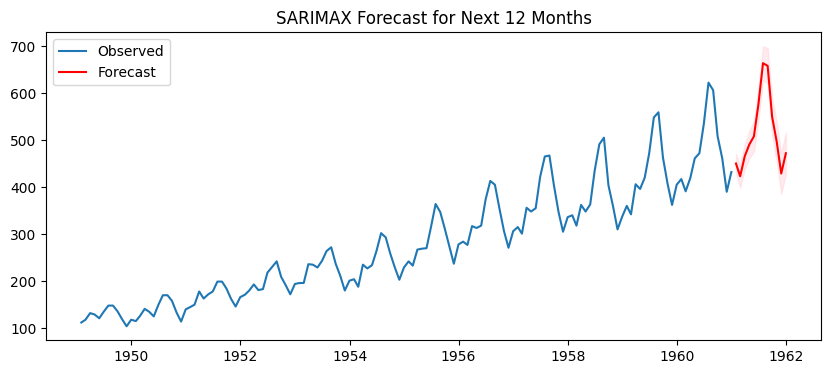

In [68]:
plt.figure(figsize=(10,4))
plt.plot(df, label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(
    conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3)
plt.legend()
plt.title('SARIMAX Forecast for Next 12 Months')
plt.show()